## LDA

Generates a topic-by-topic graph (K=16) comparing mean of obligation_constraint with mean of permission_entitlement for employers, and then another set of graphs comparing this mean for workers

In [1]:
import gensim
import pickle
import csv
import codecs
from contracts_global import doc2tokens, batchStreamObjectBranches
from joblib import Parallel, delayed

ModuleNotFoundError: No module named 'gensim'

In [ ]:


weights_file = "canadian-branch-weights.csv"

#def loadDocTerm():
#  # Should be as simple as loading the "canadian_docterm.npz" file
#  # IT WAS NOT THIS SIMPLE :(
#  doc_term_matrix = textacy.fileio.read.read_sparse_csr_matrix("./textacy/canadian_docterm.npz")
#  print(doc_term_matrix.shape)

def appendRows(row_list):
    with codecs.open(weights_file, 'a', 'utf-8') as f:
        writer = csv.writer(f)
        writer.writerows(row_list)

def appendRow(row):
    with codecs.open(weights_file, 'a', 'utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(row)

def computeWeights(doc_chunk, lda):
    # The function to be run in parallel.
    num_topics = lda.num_topics
    chunk_weights = [lda[branch_vec] for branch_vec in doc_chunk]
    # Convert to a dictionary [topic->weight]
    weight_dicts = [{elt[0]:elt[1] for elt in branch_weights} for branch_weights in chunk_weights]
    # Export the weights in the appropriate csv "slots". Important to note here
    # that lda[bag_of_words] only returns topic probabilities if they're ABOVE
    # some minimum probability. So if a topic doesn't show up in the list, then
    # we can assume the doc's probability weight for that topic is (approx) 0.
    weight_lists = [[weight_dict[n] if (n in weight_dict) else 0 for n in range(num_topics)] for weight_dict in weight_dicts]
    chunk_rows = [weight_list for weight_list in weight_lists]
    return chunk_rows

def loadDictionary():
    with open("./canadian_object_dict.pkl",'rb') as f:
        dictionary = pickle.load(f)
    return dictionary

def computeBranchWeights():
    # First we need to load the dictionary (for converting docs to bags-of-words)
    dictionary = loadDictionary()

    # Now load the LDA model
    lda = gensim.models.LdaMulticore.load("./canadian_object_lda.pkl")
    # Get the number of topics
    num_topics = lda.num_topics
    # Now we can set the header
    header_row = ["contract_id","section_num","sentence_num","statement_num","object_branch"] + ["weight_topic_" + str(n) for n in range(num_topics)]
    appendRow(header_row)

    # Load the corpus
    corpus = gensim.corpora.MmCorpus("./canadian-object-corpus-1.mm")

    # Loop through canadian-object-branches.csv and generate the topic weights
    # for each row, then output to canadian-branch-weights.csv
    # Update: load 1million lines at a time (to not break RAM) and process the
    # million lines in parallel via joblib
    # UPDATE: loop over the pre-processed .mm file to avoid re-doing the doc2bow
    # transformations

    # Use multiprocessing to process the batch in parallel
    batch_size = 200
    corpus_chunks = (corpus[i:i+batch_size] for i in range(0,len(corpus),batch_size))
    par_obj = Parallel(n_jobs=7, verbose=5)
    result_chunks = par_obj(delayed(computeWeights)(cur_chunk,lda) for cur_chunk in corpus_chunks)
    # Now flatten result_chunks
    all_rows = []
    for chunk in result_chunks:
        all_rows.extend(chunk)
    appendRows(all_rows)

    # OLD: serial processing
    #for branch_data in streamObjectBranches(include_ids=True):
    #  if row_num % 100 == 0:
    #    print("***** Processing row #" + str(row_num))
    #  cur_branch = branch_data["object_branch"]
    #  branch_bow = dictionary.doc2bow(doc2tokens(cur_branch))
    #  branch_weights = lda[branch_bow]
    #  # Convert to a dictionary [topic->weight]
    #  weight_dict = {elt[0]:elt[1] for elt in branch_weights}
    #  # Export the weights in the appropriate csv "slots". Important to note here
    #  # that lda[bag_of_words] only returns topic probabilities if they're ABOVE
    #  # some minimum probability. So if a topic doesn't show up in the list, then
    #  # we can assume the doc's probability weight for that topic is (approx) 0.
    #  weight_list = [weight_dict[n] if (n in weight_dict) else 0 for n in range(num_topics)]
    #  cur_row = [branch_data["contract_id"],branch_data["section_num"],branch_data["sentence_num"],branch_data["statement_num"],cur_branch] + weight_list
    #  appendRow(cur_row)
    #  row_num += 1

def weightTest():
    test_doc1 = "employer"
    test_doc1_bow = dictionary.doc2bow(doc2tokens(test_doc1))
    test_doc2 = "This is a sentence from a binding contract."
    test_doc2_bow = dictionary.doc2bow(doc2tokens(test_doc2))
    print(lda[test_doc1_bow])
    print(lda[test_doc2_bow])

def vectorizeDocs(cur_token_list, dictionary):
    # Converts the list of documents from strings to bag-of-words vectors
    return [dictionary.doc2bow(l) for l in cur_token_list]

def saveCorpus(vector_list, corpus_num):
    gensim.corpora.MmCorpus.serialize("./canadian-object-corpus-" + str(corpus_num) + ".mm", vector_list)

def serializeObjectBranches():
    # New version: I'm just going to load all the object branches and save in a
    # big pickle file
    doc_list = []
    doc_num = 0
    with codecs.open("./canadian-object-branches.csv",'r','utf-8') as f:
        reader = csv.reader(f)
        for row in reader:
            if doc_num % 1000 == 0:
                print("*** Processing doc #" + str(doc_num))
            doc_list.append(row[4].lower().split())
            doc_num += 1
    with open("./canadian-object-docs.pkl", 'wb') as g:
        pickle.dump(doc_list, g)

def tokenizeObjectBranches():
    doc_list = loadDocList()
    doc_tokens = [doc.lower().split() for doc in doc_list]
    with open("./canadian-object-tokens.pkl", 'wb') as g:
        pickle.dump(doc_tokens, g)

def loadDocList():
    # Loads the doc list created by serializeObjectBranches()
    with open("./canadian-object-docs.pkl", 'rb') as f:
        doc_list = pickle.load(f)
    return doc_list

def loadTokenList():
    with open("./canadian-object-tokens.pkl", 'rb') as f:
        token_list = pickle.load(f)
    return token_list

def constructStaticCorpus():
    # Construct the static corpus in parallel, to make the weight computations
    # quicker
    dictionary = loadDictionary()
    token_list = loadTokenList()
    # Use multiprocessing to process batches of docs in parallel
    batch_size = 10000
    token_chunks = [token_list[i:i+batch_size] for i in range(10000000,len(token_list),batch_size)]
    par_obj = Parallel(n_jobs=7, verbose=5)
    chunk_vectors = par_obj(delayed(vectorizeDocs)(cur_chunk, dictionary) for cur_chunk in token_chunks)
    # Now put the chunks together and save in mm format
    all_docs = []
    for chunk in chunk_vectors:
        all_docs.extend(chunk)
    saveCorpus(all_docs, 2)


In [3]:
from IPython.display import Image

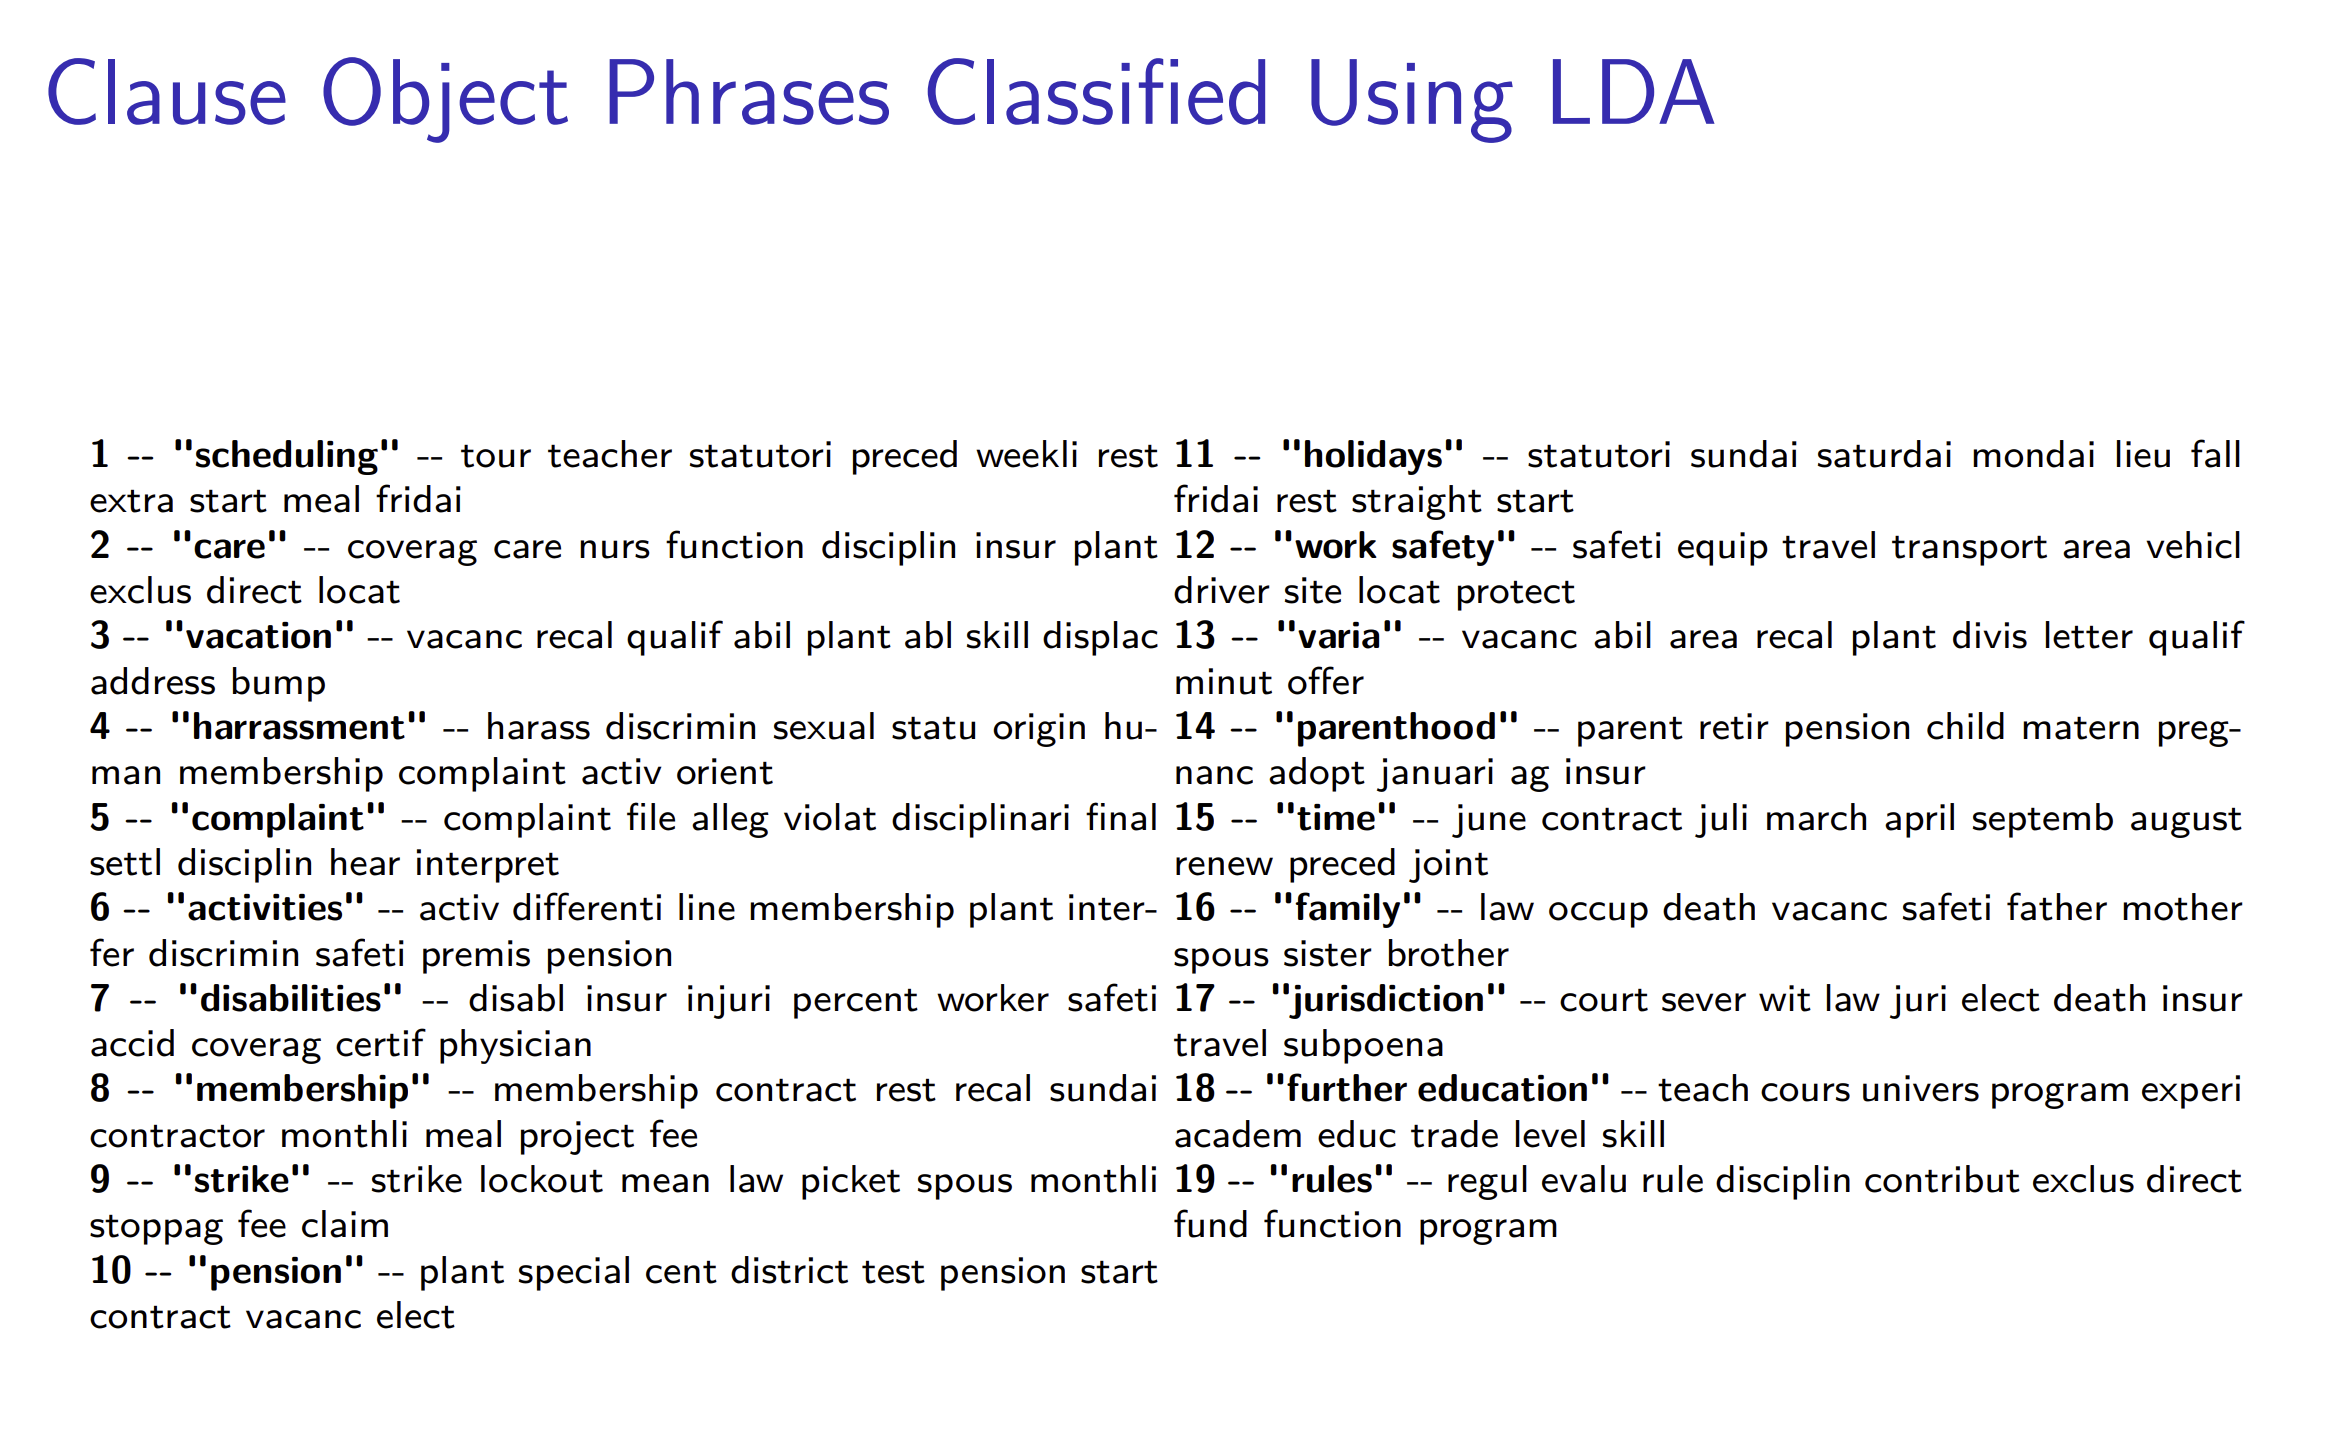

In [4]:
Image("././lda_topics.png")

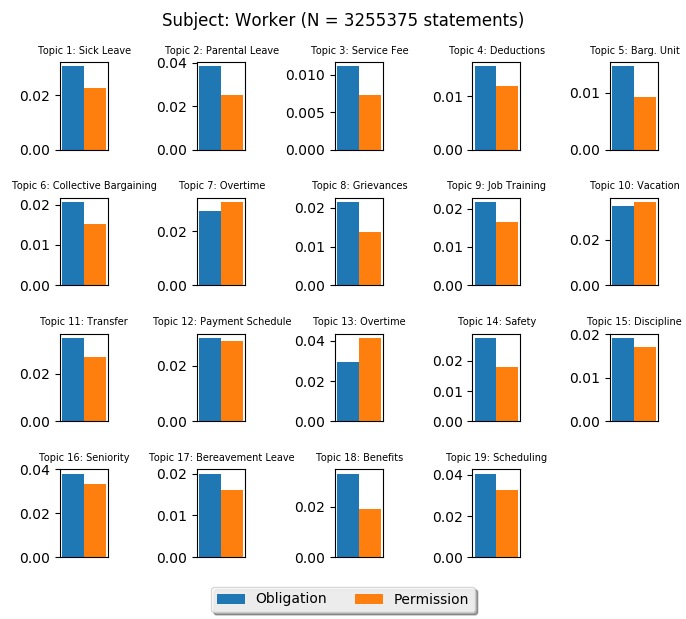

In [2]:
Image("./worker_v3.png")